# Scheidegger model of river networks
This notebook is an illustration of the stochastic Scheidegger river network model. 

In [188]:
import numpy as np, seaborn as sns, random
import matplotlib.pyplot as plt, matplotlib as mpl
%matplotlib inline
from sklearn import linear_model

In [175]:
# Create the Scheidegger model. 
# Size of the simulation (width of square matrix).
mat_n = 10
# Matrix of random values. 
sch_mat = (np.round(np.random.rand(mat_n, mat_n)) - 0.5)*2
# Matrix of ones to comprise the Y direction of the quiver vector. 
V = -np.ones([mat_n, mat_n])

# Multiply by a mask (1, 0, 1, 0; 0, 1, 0, 1) matrix to offset each row. 
mask = np.tile(np.identity(2), (int(mat_n/2),int(mat_n/2)))
sch_mat = mask*sch_mat
V = mask*V

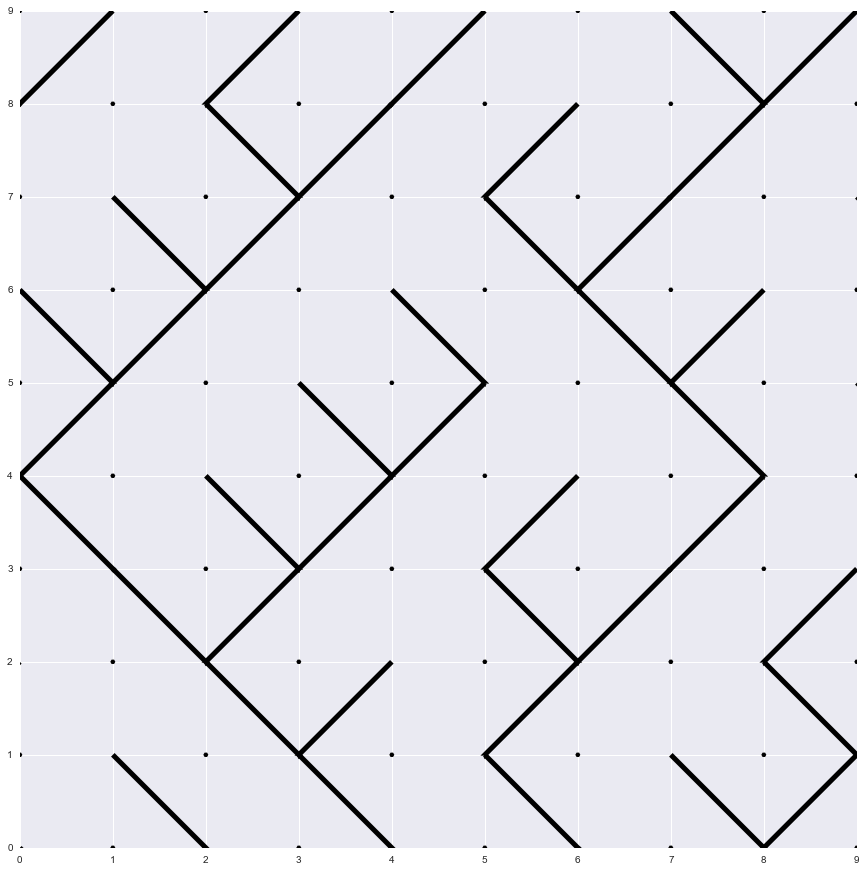

In [176]:
# Plot the quiver. 
plt.figure(figsize=(15,15))
plt.quiver(sch_mat, V, headwidth=0, scale=mat_n*0.75)

In [201]:
downstream_ids

[0, 3, 1, 7, 6, 10, 4, 5, 8, 3, 8]

In [197]:
# List to choose from randomly for downstream step. 
left_or_right = [-1, 1]

# Start with a list of indices. 
all_ids = [ [i] for i in range(mat_n)]

# Repeat this process for each row. 
for row_n in range(mat_n):

    downstream_ids = []
    # For each stream represented by these indices... 
    for i, stream_ids in enumerate(all_ids):
        # Check that the streams are within the bounds of the box. If not, don't do anything to them. 
        if (stream_ids[-1] >=0) and (stream_ids[-1] <= mat_n - 1):
            # Choose whether to go left or right downstream.
            # Count the number of upstream points that are left or right of the stream. 
            left = len([j for j in stream_ids if j < stream_ids[-1]])
            right = len([j for j in stream_ids if j > stream_ids[-1]])
            
            # 
            downstream_idx = random.choice(left_or_right) + stream_ids[-1]
            # Check if this index is already in the list (a confluence). 
            if downstream_idx in downstream_ids:
                # Find where it is in downstream_ids.
                extend_i = downstream_ids.index(downstream_idx)
                # And remove the last-placed entry in the list of lists (because it was just added, and we will add it again now.)
                all_ids[extend_i].pop()
                # Combine the two lists of arrays, taking the lower id number. 
                all_ids[extend_i].extend(all_ids[i])
                concat_i = extend_i
                # Also remove this old channel from 'ids'.
                all_ids.pop(extend_i)
            else:
                concat_i = i
            # Make an array so we know which channels need to be re-started (and re-appended).
            downstream_ids.append(downstream_idx)
            # Append channels to the ids, we can keep track of all indices that feed into a particular stream. 
            all_ids[concat_i].append(downstream_idx)

    # Check to see if any indices are missing and, if so, add them to the list.
    for i in range(mat_n):
        if i not in downstream_ids:
            all_ids.append([i])

In [198]:
all_ids

[[9, 10, 10, 4, 3, 8, 7, 6, 1, 0],
 [1, 0, -1, 3],
 [2, 1, 0, 1, 0, 1],
 [2, 8, 7],
 [5, 6],
 [8, 9, 10],
 [2, 3, 3, 4],
 [5, 4, 5],
 [9, 10, 8],
 [4],
 [5],
 [9],
 [5],
 [2],
 [9]]

## Drainage area
The drainage areas, just like the channels, can be defined as the diamond around each point of channel origination. These squares are therefore non-overlapping and it is completely unambiguous which areas correspond to which points. 

We can therefore calculate the drainage area of the scheidegger model of each channel.

Each row is a sequence of -1s and 1s of length N. There is also an 'area' matrix of the same size. Below it is another vector of length N-1. For each number in the row, if the number is I, add area(i) to area(i+I). 

Any points where area = 1 is the start of a channel. 

In [150]:
# Create a drainage area matrix, 'area', initialized to 1's. 
area = np.ones(sch_mat.shape)
# Loop over each row and column in the Scheidegger matrix. 
for i, row in enumerate(sch_mat):
    if i<len(sch_mat)-1:
        for j, elem in enumerate(row):
            # Create 'ds_idx', which is the downstream index that the element i,j goes to.
            ds_idx = int(j + sch_mat[i,j])
            # Deal with edge effects. If ds_idx < 0 or > # cols, then don't do anything - this channel just disappears. 
            if ( ds_idx >=0 ) and ( ds_idx < sch_mat.shape[1]):
                # Otherwise, sum up the areas. 
                area[i+1, ds_idx] += area[i, j]

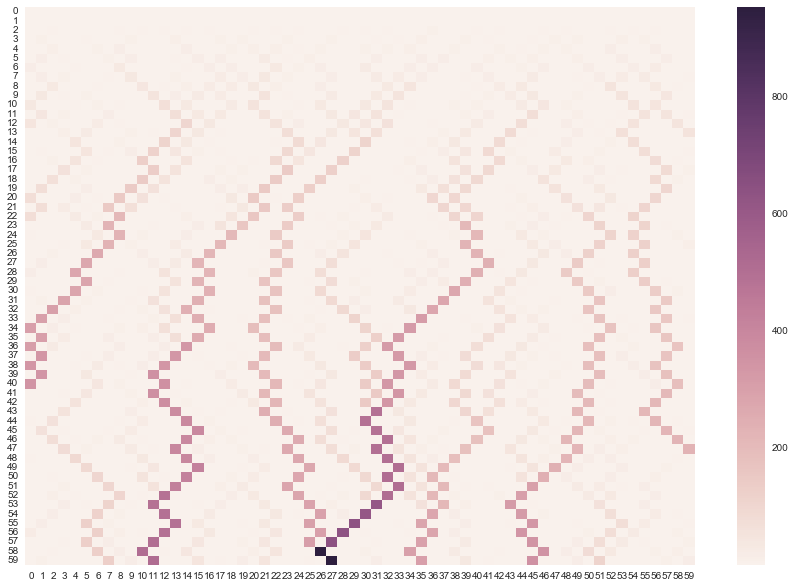

In [46]:
# Plot a heatmap of the area.
plt.figure(figsize=(15,10))
sns.heatmap(area)

## Longest channel
We create an array of 1s indicating length, max_l. 

At each point, we move downstream, and add the max of the list of values that are upstream. 

In [151]:
# Create a max length matrix, 'length', initialized to 1's. 
length = np.ones(sch_mat.shape)

# Loop over rows and columns of sch_mat.
for i, row in enumerate(sch_mat):
    if i<len(sch_mat)-1:
        for j, elem in enumerate(row):
            # Downstream index being referenced.
            ds_idx = int(j + sch_mat[i,j])
            # Take the maximum value between the upstream value + 1 and the current value. 
            if ( ds_idx >=0 ) and ( ds_idx < sch_mat.shape[1]):
                length[i+1, ds_idx] = np.amax([length[i+1, ds_idx], length[i, j] + 1])

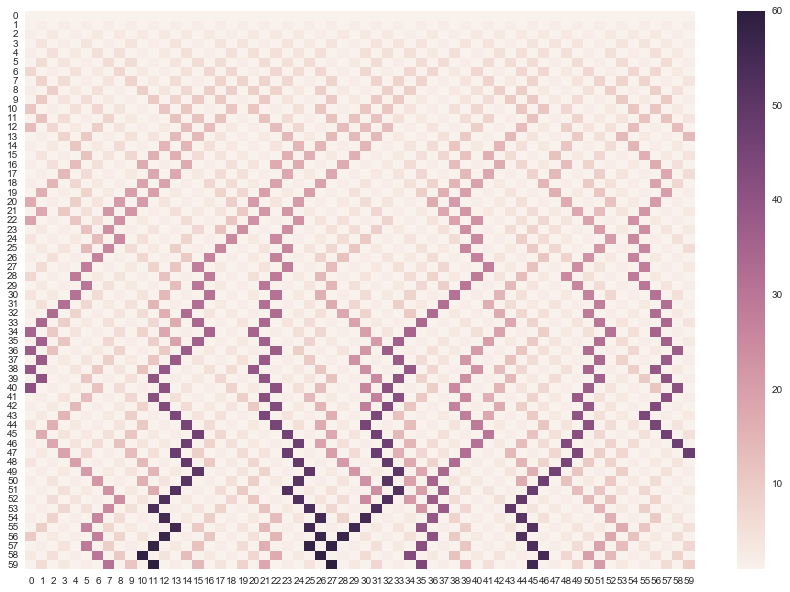

In [51]:
# Plot a heatmap of the area.
plt.figure(figsize=(15,10))
sns.heatmap(length)

## Plot length and area against each other and calc Hack exp.

In [159]:
# Mask the resulting area and length arrays so the off-grid elements are zero'd.
all_areas = (area*mask).reshape((1,-1))
all_lengths = (length*mask).reshape((1,-1))
# Remove these off-grid elements for the analysis.
all_lengths = all_lengths[all_lengths > 0]
all_areas = all_areas[all_areas > 0]
# Plot the behavior of area vs length. 
log_a = np.log10(all_areas).reshape(-1,1)
log_l = np.log10(all_lengths).reshape(-1,1)
# Prune the smallest areas and lengths. 
idx = ((log_a>2.2) & (log_a<2.7))
log_a = log_a[idx]
log_l = log_l[idx]

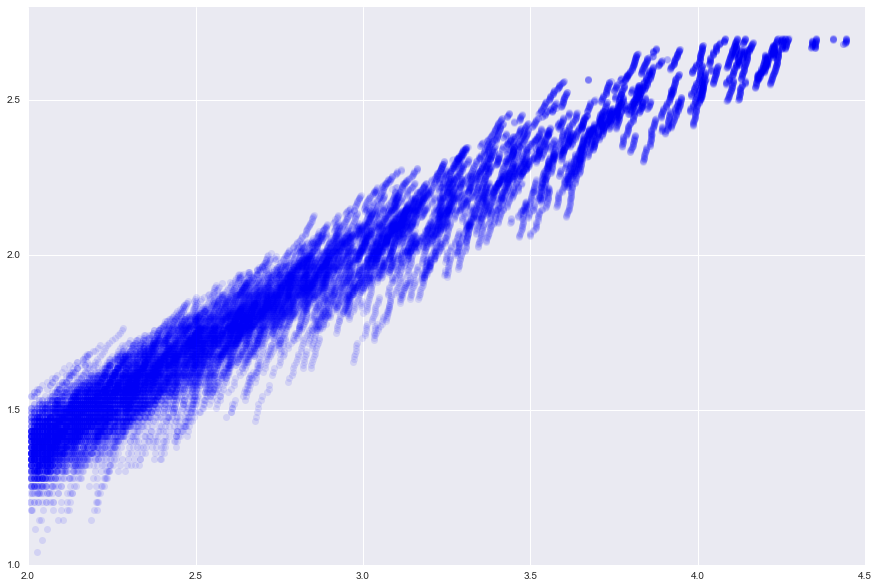

In [140]:
plt.figure(figsize=(15,10))
plt.plot(log_a, log_l, 'bo', lpha=0.1)

In [160]:
# Fit a linear regression to the data. 
regr = linear_model.LinearRegression()
regr.fit(log_a.reshape(-1,1), log_l.reshape(-1,1))
#plt.plot([0, 5], [0, regr.coef_*5], 'r-')
print(regr.coef_)

[[ 0.66111264]]


# Dodds-Rothman model
We now weight the river direction probability by the drainage basin area. 

We must do this row by row. 

In [ ]:
[ l 0 r 0 l 0 l 0 r ]
[ 0 r 0 l 0 l 0 l 0 ]

In [165]:
mat_n = 100

# Create two drainage area matrices that indicate the area from the left and the drainage area to the right.  
area_l = np.ones(sch_mat.shape)
area_r = np.ones(sch_mat.shape)

# Loop over each row and column in the Scheidegger matrix. 
for i, row in enumerate(sch_mat):
    if i<len(sch_mat)-1:
        
        # Loop over all upstream rows and check the areas to the left and right of each point. 
        for up_i in range(i):
            
        for j, elem in enumerate(row):
            # For each element, check if the area from the left or the right is larger. 
            # Create 'ds_idx', which is the downstream index that the element i,j goes to.
            ds_idx = int(j + sch_mat[i,j])
            # Deal with edge effects. If ds_idx < 0 or > # cols, then don't do anything - this channel just disappears. 
            if ( ds_idx >=0 ) and ( ds_idx < sch_mat.shape[1]):
                # Otherwise, sum up the areas. 
                area[i+1, ds_idx] += area[i, j]
